# 0. General imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import math

# 1. Autocorrelation features

## 1.0. Specific imports

In [3]:
from scipy.optimize import curve_fit
from scipy.spatial import distance


## 1.1 Computation

In [4]:
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

In [5]:
def damped_sine(m, A, k, f, phi):
    return A * np.exp(-k * m) * np.cos(2 * np.pi * f * m + phi)

In [6]:
def dtw(x,y,w=np.Inf):    
    Nx=np.size(x)
    Ny=np.size(y)
    x_=np.reshape(x,(Nx,1))
    y_=np.reshape(y,(Ny,1))
    # Computation of the distance matrix
    D=distance.cdist(x_, y_, 'euclidean')**2
    # Computation of the cumulative distance matrix
    C=np.Inf*np.ones((Nx+1,Ny+1))
    C[0,0]=0    
    for i in range(1,Nx+1):
        for j in range(int(np.maximum(1,i-w)),int(np.minimum(Ny+1,i+w+1))):
            C[i,j] = D[i-1,j-1] + np.amin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
    # Computation of the path
    path=[[Nx-1,Ny-1]]
    i=Nx-1
    j=Ny-1
    while i>0 and j>0:
        ind=np.argmin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
        if ind==0:
            path = np.insert(path, 0, [i-1, j-1], axis=0)
            i-=1
            j-=1
        elif ind==1:
            path = np.insert(path, 0, [i-1, j], axis=0)
            i-=1
        elif ind==2:
            path=np.insert(path, 0, [i, j-1], axis=0)
            j-=1
        
    return np.sqrt(C[Nx,Ny]),path

In [7]:
def fit_autocorrelation(data,
        p0 = [1, 0.01, 0.05, 0],
        model = damped_sine,
        maxLags = 100):

    try:
        gammax, lags = autocorrelation(data.values, maxLags)
        positive_lags = lags[lags >= 0]
        autocorr = gammax[lags >= 0]
        lags_fit = positive_lags[1:]
        autocorr_fit = autocorr[1:]
        popt, _ = curve_fit(damped_sine, lags_fit, autocorr_fit, p0=p0, maxfev =10000)
        A_fitted, k_fitted, f_fitted, phi_fitted = popt

    except RuntimeError:
        popt = p0

    autocorr_fitted = damped_sine(positive_lags, *popt)
    reconstruction_error,_ = dtw(autocorr_fit, autocorr_fitted)

    return A_fitted, k_fitted, f_fitted, phi_fitted, reconstruction_error


## 1.2. Plot

In [8]:
def plot_autocorrelation_visualisation(data, axis = None, maxLags = 100):
    autocorrelation_real, lags = autocorrelation(data.values, maxLags)
    autocorrelation_real = autocorrelation_real[lags > 0]
    lags = lags[lags > 0]

    autocorrelation_model = damped_sine(lags, data.A_fitted, data.k_fitted, data.f_fitted, data.phi_fitted)

    if axis != None:
        axis.plot(lags, autocorrelation_real, linestyle='-', color='blue', label='Autocorrélation')
        axis.plot(lags, autocorrelation_model, linestyle='--', color='red', label='Modèle ajusté')
        axis.legend()
        axis.set_title(f'Autocorrélation - {data.database_name} {data.index}')
        axis.text(0.05, 0.95, f'A={data.A_fitted:.2f}\nk={data.k_fitted:.2f}\nf={data.f_fitted:.2f}\nphi={data.phi_fitted:.2f}\nDTW={data.reconstruction_error:.2f}',
                transform=axis.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        axis.set_ylabel('$\hat{{\gamma}}_x[m]$')
        axis.set_xlabel('Décalage $m$')
        axis.grid(True)
        return axis
    
    plt.plot(lags, autocorrelation_real, linestyle='-', color='blue', label='Autocorrélation')
    plt.plot(lags, autocorrelation_model, linestyle='--', color='red', label='Modèle ajusté')
    plt.legend()
    plt.title(f'Autocorrélation - {data.database_name} {data.index}')
    plt.text(0.05, 0.95, f'A={data.A_fitted:.2f}\nk={data.k_fitted:.2f}\nf={data.f_fitted:.2f}\nphi={data.phi_fitted:.2f}\nDTW={data.reconstruction_error:.2f}',
            transform=axis.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.ylabel('$\hat{{\gamma}}_x[m]$')
    plt.xlabel('Décalage $m$')
    plt.grid(True)


# 2. Shannon entropy feature

## 2.1. Computation

In [9]:
def my_fft(x,
            Fs = 46000):        
    N=np.size(x)
    
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)

    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    
    # Only the positive spectrum is considered
    return X[f>=0],f[f>=0]


In [10]:
def shannon_entropy(signal):            
    dft, f = my_fft(signal)
    spectral_distribution = (np.abs(dft)**2)/np.sum(np.abs(dft)**2)
    H = -np.sum(spectral_distribution*np.log(spectral_distribution))
    return H

# 3. Segmentation feature

## 3.0. Specific imports

In [11]:
from ruptures.base import BaseCost
import ruptures as rpt


## 3.1. Computation

In [12]:
class Shannon_entropy_cost(BaseCost):
    # The 2 following attributes must be specified for compatibility.
    model = ""
    min_size = 2

    def fit(self, signal):
        self.signal = signal
        return self

    def error(self, start, end):
        signal_portion = self.signal[start:end]
        return shannon_entropy(signal_portion)

In [13]:
def segmentation(signal,
                scaling_factor = 0.03,          # Value obtained by a previous analysis
                min_size = 2):                  # Value obtained by a previous analysis

    pen = scaling_factor*np.std(signal)*np.log(len(signal))
    loss = Shannon_entropy_cost()
    algo = rpt.Pelt(model = "l2", custom_cost = loss, min_size = min_size).fit(signal)
    bkps = algo.predict(pen = pen)

    return bkps

## 3.2. Plot

In [14]:
def plot_segmentation(data, figure = None, figsize = (8,5)):
    segmentation_fig, segmentation_axes = rpt.show.display(data.values, data.bkps, figsize = figsize)

    if figure == None:
        plt.title(f'Segmentation {data.database_name} {data.index}')
        plt.xlabel('time (unknown)')
        plt.ylable('Amp (unknown)')
        return segmentation_fig, segmentation_axes
    
    else:
        for i, ax in enumerate(segmentation_axes):
            ax.set_title(f'Segmentation {data.database_name} {data.index}')
            ax.set_xlabel('time (unknown)')
            ax.set_ylable('Amp (unknown)')
            figure._axstack.add(figure._make_key(ax), ax)  # Link axes to the main figure

            # Position axes in the grid
            figure.axes[i].set_position(ax.get_position())

            return figure





# 4. Spectral emission band width

## 4.1 Computation

In [15]:
def periodogram(x):        
    X, f = my_fft(x)
    Gammax=(np.abs(X)**2)/np.size(x)
    normalised_Gammax = Gammax/np.max(Gammax)

    
    return Gammax, normalised_Gammax, f

In [16]:
def find_f_min(f, Gammax,
                epsilon = 0.035):           # Value obtained by a previous analysis
    i = 0

    while Gammax[i]<epsilon and i<len(f)-1:
        i += 1
    
    return i, f[i]

In [17]:
def find_f_max(f,Gammax,
                epsilon = 0.035):           # Value obtained by a previous analysis
    i = len(f) - 1
    
    while Gammax[i]<epsilon and i>0:
        i = i - 1
    
    return i, f[i]

In [18]:
def emission_band(x):
    Gammax, normalised_Gammax, f = periodogram(x)
    f_min_index, f_min =  find_f_min(f, normalised_Gammax)
    f_max_index, f_max =  find_f_max(f, normalised_Gammax)
    emission_band_width = f_max - f_min

    return f_min, f_max, emission_band_width


## 4.2 Plot

In [19]:
def get_dsp_emission_band(data, f, Gammax):
    emission_band = np.zeros(len(f))

    if data.f_max_index == len(f)-1:
        include = 0
    
    else:
        include = 1

    emission_value = np.max(Gammax)

    f_min_index = list(f).index(data.f_min)
    f_max_index = list(f).index(data.f_max)

    emission_band[f_min_index : f_max_index + include] = emission_value
    
    return emission_band

In [20]:
def plot_DSP(data, axis = None, normalise = False):
    Gammax, normalised_Gammax, f = periodogram(data.values)
    

    if normalise:
        Y = normalised_Gammax
        title_prefix = 'Normalised '
        
    else:
        Y = Gammax
        title_prefix = ''

    emission_band = get_dsp_emission_band(data, f, Y)

    if axis != None:
        axis.plot(f, Y, linestyle='-', color='blue', label= f'{title_prefix}DSP')
        axis.plot(f, emission_band, linestyle='--', color='red', label=f'{title_prefix}Emission band')
        axis.legend()
        axis.set_title(f'Autocorrélation - {data.database_name} {data.index}')
        axis.set_ylabel(f'{title_prefix}$\hat{{\Gamma}}_x[f]$')
        axis.set_xlabel('f')
        axis.grid(True)
        return axis
    
    
    plt.plot(f, Y, linestyle='-', color='blue', label= f'{title_prefix}DSP')
    plt.plot(f, emission_band, linestyle='--', color='red', label=f'{title_prefix}Emission band')
    plt.legend()
    plt.title(f'Autocorrélation - {data.database_name} {data.index}')
    plt.ylabel(f'{title_prefix}$\hat{{\Gamma}}_x[f]$')
    plt.xlabel('f')
    plt.grid(True)

# 5. General Statistical Features

## 5.1. Computation

In [21]:
# Function to compute the relative energy in Nb frequency band
def relative_energy(x,Nb,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=Fs/2
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>0) & (f<=Fs/2)])**2)
    return E

def compute_features(X):
    N,M=np.shape(X)
    Y=np.zeros((8,M))
    for i in range(M):
        Y[0,i]=np.mean(X[:,i])
        Y[1,i]=np.var(X[:,i])
        Y[2,i]=np.sqrt(np.sum(X[:,i]**2))
        E=relative_energy(X[:,i],5,46000)
        Y[3:8,i]=E
    return Y

# 6 Data-wise computation

## 6.1 Codes

In [23]:
class Data():
    def __init__(self, index, values,  database_name = ''):
        self.index = index
        self.database_name = database_name

        # Delete the first value because it is the class of the data, which is supposed to be unknown for this project
        self.values = values[1:]

        # Convert the values to numpy for easy computation
        self.values = np.array(self.values)

        # Autocorrelation features
        self.A, self.k, self.f, self.phi, self.reconstruction_error = fit_autocorrelation(self)

        # Shannon entropy feature
        self.H = shannon_entropy(self.values)

        # Segmentation feature
        self.bkps = segmentation(self.values)

        # Emission band features
        self.f_min, self.f_max, self.emission_band_width = emission_band(self.values)

        # class is 0 by default
        self.k_mean_class_label = 0
        self.deviation_class_label = 0

# 7. Feature analysis

## 7.1. Computation

In [24]:
def my_pca(X):
    print(np.shape(X))
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

## 7.2. Plots

In [25]:
def plot_distribution(name, distribution, database_name, axis = None, bins_number = 30):
    if axis != None:
        axis.hist(distribution, bins = bins_number)
        axis.set_title(f'{database_name} - {name} distribution')
        axis.set_xlabel('Value')
        axis.set_ylabel('Number of data')
        return axis

    plt.hist(distribution, bins = bins_number)
    plt.title(f'{database_name} - {name} distribution')
    plt.xlabel('Value')
    plt.ylabel('Number of data')

In [26]:
def plot_PCA(database, features_contributions, feature_names, data_projections, principal_component_variance_contribution, database_name = '', clustering = '', plot_pca_circle = False):

    U = features_contributions
    feature_names = feature_names
    data_projections = data_projections
    var_exp = principal_component_variance_contribution

    if plot_pca_circle:
        D,D=np.shape(U)
        figure, axes = plt.subplots()
        for d in range(D):
            plt.plot([0,U[d,0]],[0,U[d,1]])
            plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
        theta = np.linspace(0, 2*np.pi, 100)
        radius = 1
        a = radius*np.cos(theta)
        b = radius*np.sin(theta)
        axes.set_aspect(1)
        plt.plot(a,b,'k') 

    v=np.round(1000*var_exp/np.sum(var_exp))/10
        
          

    datas_pc1 = data_projections[0,:]
    datas_pc2 = data_projections[1,:]

    if clustering == 'k_mean':
        plt.scatter(datas_pc1, datas_pc2, c=database.data_k_mean_class_labels, cmap='viridis', marker='o')
        title_complement = 'with k_mean cluster coloring'
    elif clustering == 'deviation':
        plt.scatter(datas_pc1, datas_pc2, c=database.data_deviation_class_labels, cmap='viridis', marker='o')
        title_complement = 'with deviation cluster coloring'
    elif clustering == 'deviation_socres':
        plt.scatter(datas_pc1, datas_pc2, c=database.deviation_scores, cmap='viridis', marker='o')
        title_complement = 'with deviation score coloring'
    else:
        plt.scatter(datas_pc1, datas_pc2)
        title_complement = ''

    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.title(f'{database.name} - PCA - {title_complement}')
    plt.show()

In [27]:
def plot_PCA_circle(features_contributions, feature_names, data_projections, principal_component_variance_contribution, database_name = ''):

    U = features_contributions
    feature_names = feature_names
    data_projections = data_projections
    var_exp = principal_component_variance_contribution


    D,D=np.shape(U)
    figure, axes = plt.subplots()
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')   

    datas_pc1 = data_projections[0,:]
    datas_pc2 = data_projections[1,:]
    #plt.scatter(datas_pc1, datas_pc2)

    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.title(f'{database_name} - PCA')
    plt.show()

# 8. Clustering

## 8.0. Specific imports and utils

In [28]:
from sklearn.cluster import KMeans
import numpy as np

In [29]:
def get_reduced_feature_matrix(database, features_names):
    Y = []
    for feature_name in features_names:
        feature_index = database.feature_names.index(feature_name)
        Y.append(database.X[feature_index,:])
    Y = np.array(Y)
    return Y

## 8.1. K-means clustering computation

In [30]:
def k_mean_clustering(database, features_names, class_number = 2):

    Y = get_reduced_feature_matrix(database, features_names)
    # Get the transposed matrix for compatibility with sklearn.cluster's KMeans
    Y = np.transpose(Y)

    kmeans = KMeans(n_clusters=class_number, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(Y)


    return kmeans.labels_

## 8.2. Plots

In [31]:
def plot_database_in_3_features_space(features_names, database, clustering = ''):
    database_feature_projections = get_reduced_feature_matrix(database, features_names)
   

    # Création de la figure et de l'axe 3D
    fig = plt.figure(figsize = (8,15))
    ax = fig.add_subplot(111, projection='3d')

    if clustering == 'k_mean':
        labels = database.data_k_mean_class_labels
        title_complement = 'with k_mean cluster coloring'

    
    else:
        labels = database_feature_projections[2,:]
        title_complement = ''
        

    # Nuage de points 3D
    ax.scatter(database_feature_projections[0,:], database_feature_projections[1,:], database_feature_projections[2,:], c=labels, cmap='viridis', marker='o')

    # Étiquettes des axes
    ax.set_xlabel(f'{features_names[0]}')
    ax.set_ylabel(f'{features_names[1]}')
    ax.set_zlabel(f'{features_names[2]}')
    ax.set_title(f'{database.name} feature projection plot {title_complement}')

    # Affichage
    plt.show()

# 9. Database object definition

In [32]:
class Database():
    def __init__(self, name, datas):
        self.name = name
        self.datas = datas
        self.data_matrix = np.transpose(np.array([data.values for data in self.datas]))

        for data in self.datas:
            data.database_name = self.name
        
        # Usual statistical info
        statistical_features = compute_features(self.data_matrix)

        self.means = list(statistical_features[0,:])
        self.vars = list(statistical_features[1,:])
        self.L2_norms = list(statistical_features[2,:])
        self.energies = list([statistical_features[i,:] for i in range(3,len(statistical_features))])
        self.energies_names = [f'E{i}' for i in range(len(self.energies))]


        # Autocorrelation features distribution
        self.A_distribution = [data.A for data in self.datas]
        self.k_distribution = [data.k for data in self.datas]
        self.f_distribution = [data.f for data in self.datas]
        self.phi_distribution = [data.phi for data in self.datas]
        self.reconstruction_error_distribution = [data.reconstruction_error for data in self.datas]

        # Shannon entropy feature distribution
        self.H_distribution = [data.H for data in self.datas]

        # Segmentation feature distribution
        self.breaks_distribution = [len(data.bkps) for data in self.datas]

        # Emission band features distribution
        self.f_min_distribution = [data.f_min for data in self.datas]
        self.f_max_distribution = [data.f_min for data in self.datas]
        self.emission_band_width_distribution = [data.emission_band_width for data in self.datas]

        # Feature matrix
        self.X = [self.A_distribution,
                            self.k_distribution,
                            self.f_distribution,
                            self.phi_distribution,
                            self.reconstruction_error_distribution,
                            self.H_distribution,
                            self.breaks_distribution,
                            self.f_min_distribution,
                            self.f_max_distribution,
                            self.emission_band_width_distribution,
                            self.means,
                            self.vars,
                            self.L2_norms
                            ]

        
        self.X = self.X + self.energies
        self.X = np.array(self.X)

        self.feature_names = ['A', 'k', 'f', 'phi', 'rec_err','H','breaks','f_min','f_max','width'] + ["mean", "var", "L2"] + self.energies_names 
        

        # PCA analysis
        #self.features_contributions, self.data_projections, self.principal_component_variance_contribution = my_pca(self.X)

        # No class labels by default
        self.data_k_mean_class_labels = []
        self.data_deviation_class_labels = []
        self.deviation_scores = []

    def PCA(self, selected_features_names):
        Y = get_reduced_feature_matrix(self, selected_features_names)
        return my_pca(Y)

    def k_mean_clustering(self, features_names):
        # K-means clustering
        self.data_k_mean_class_labels = k_mean_clustering(self, features_names)

        for data_index, class_label in enumerate(list(self.data_k_mean_class_labels)):
            self.datas[data_index].k_mean_class_label = class_label

    



# 10. Loading

In [ ]:
from tqdm import tqdm

In [33]:
def load_database(database_path):
    datas = []

    with open(database_path, 'r') as file:

        for data_index, raw_data in enumerate(tqdm(file, desc = "Loading and processing datas")):
            raw_data_line = raw_data.strip('\n').split(' ')
            data_values = []
            for raw_value in raw_data_line:
                if len(raw_value)!=0:
                    data_values.append(float(raw_value))

            datas.append(Data(data_index, data_values))
        
    name = database_path.strip('.txt').split('/')[-1]
    return Database(name, datas)

In [34]:
train_database_path = '/teamspace/studios/this_studio/Données/FordB_TRAIN.txt'
test_database_path = '/teamspace/studios/this_studio/Données/FordB_TEST.txt'

The code below is expected to run for at least 3m 30s

In [35]:
train_database = load_database(train_database_path)
test_database = load_database(test_database_path)

Loading and processing datas: 3636it [02:31, 24.02it/s]
Loading and processing datas: 810it [00:33, 24.30it/s]


# 11. Distribution analysis

## 11.1. Train database

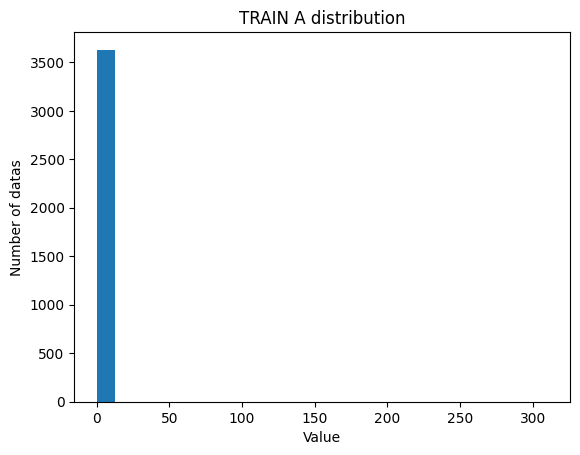

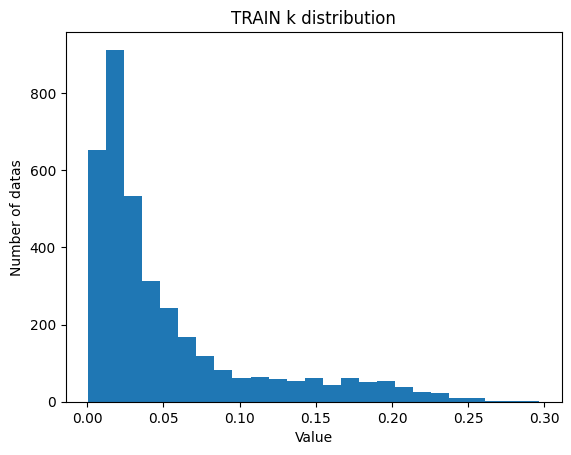

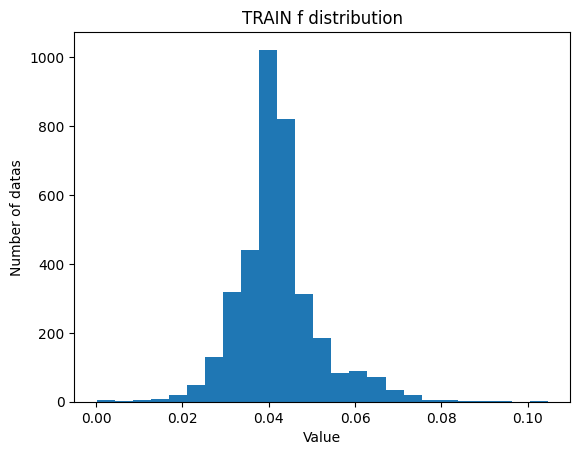

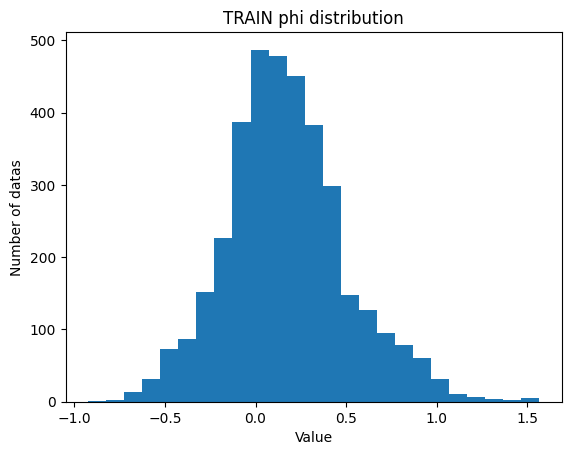

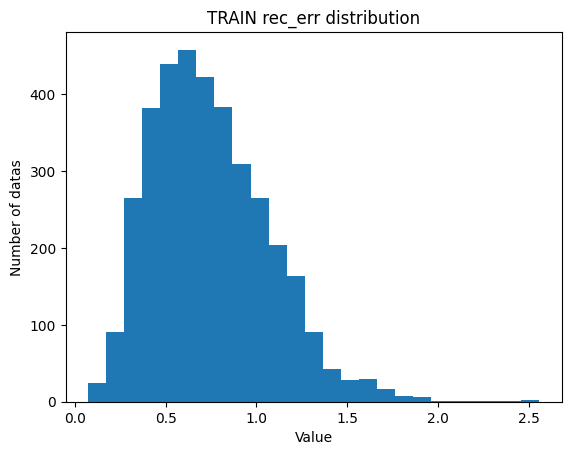

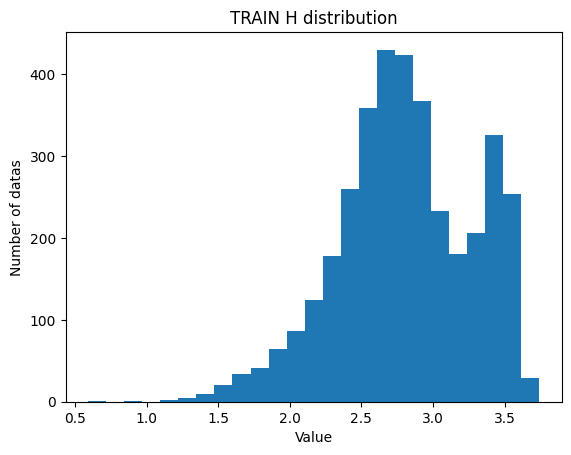

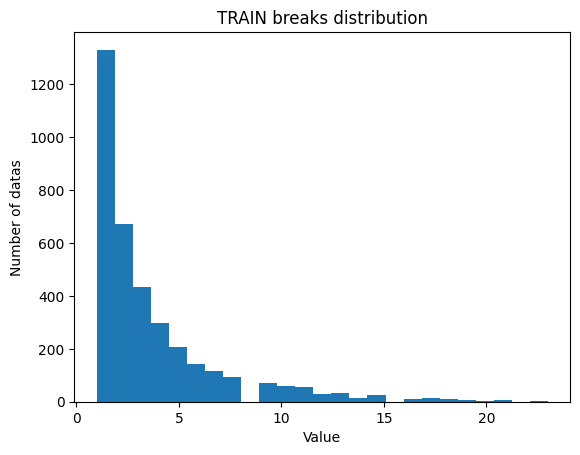

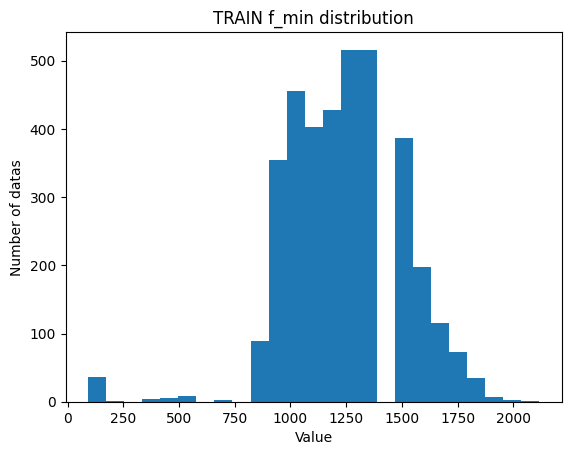

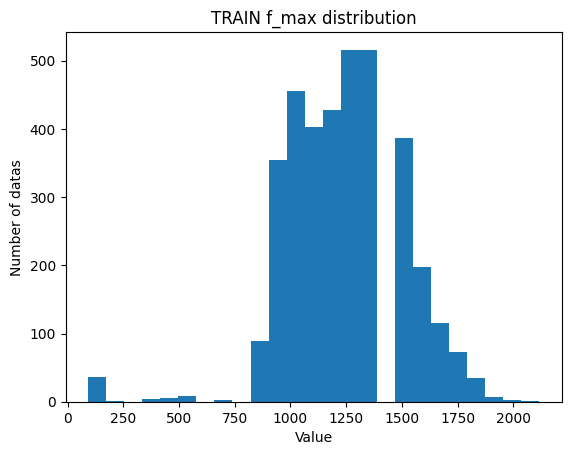

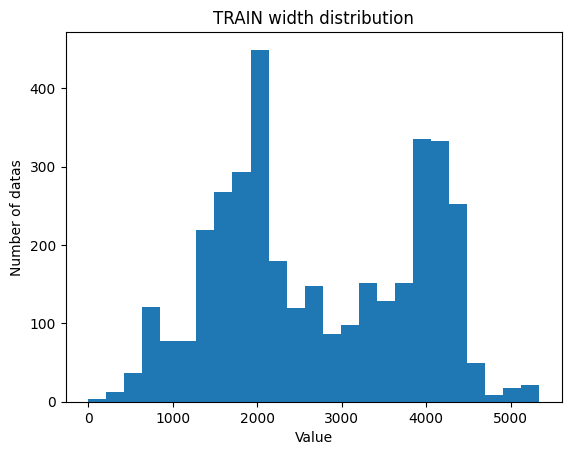

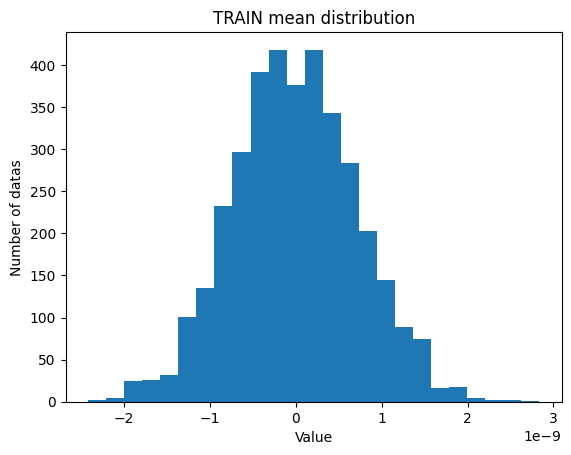

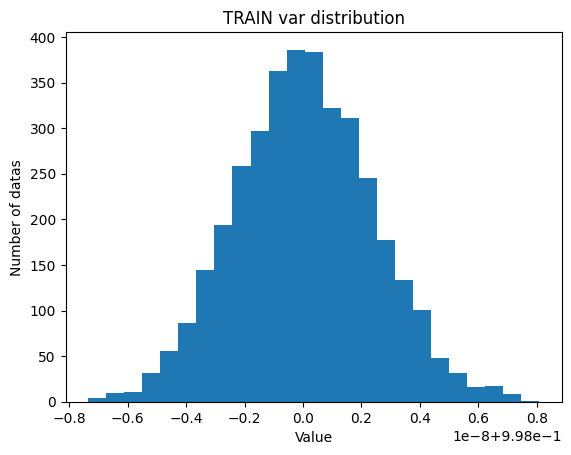

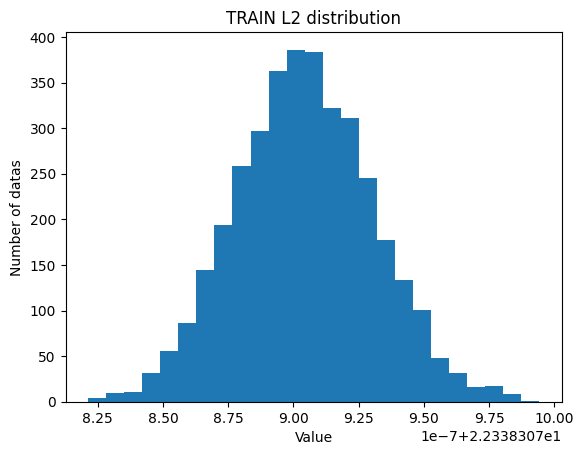

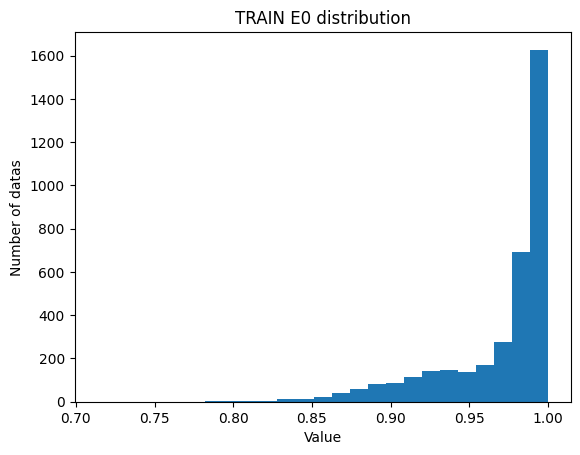

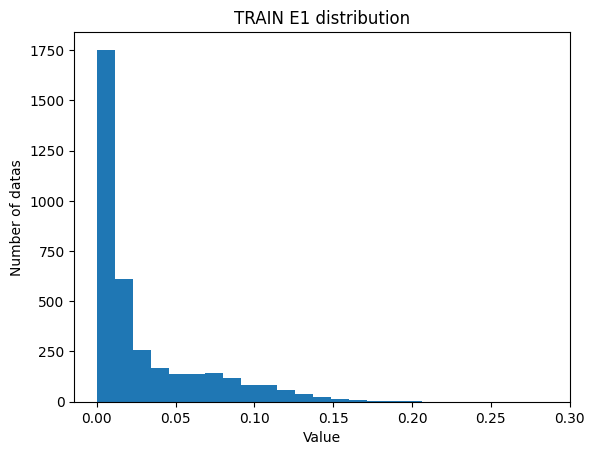

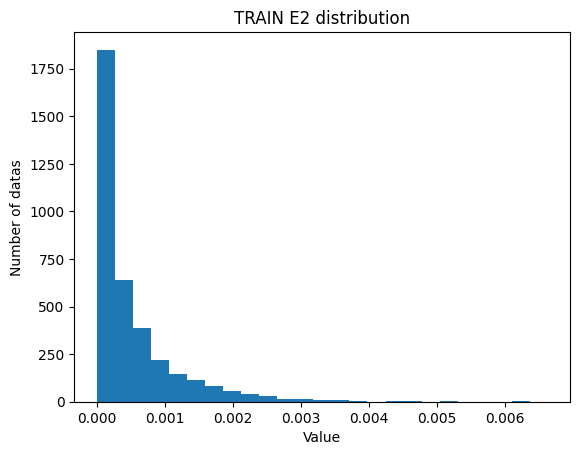

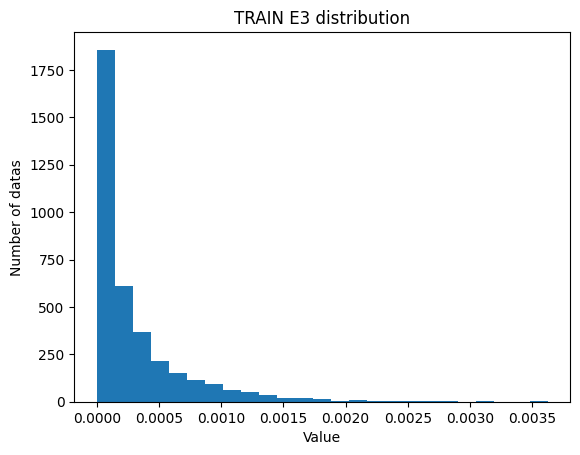

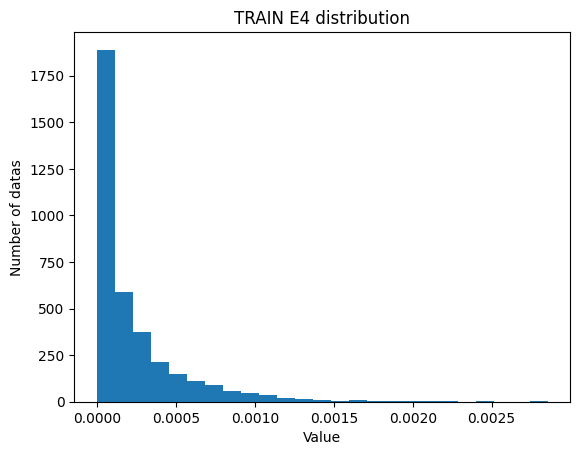

In [36]:
for feature_index, feature_name in enumerate(train_database.feature_names):
    plt.clf()
    plt.hist(train_database.X[feature_index,:], bins = 25)
    plt.title(f'TRAIN {feature_name} distribution')
    plt.xlabel('Value')
    plt.ylabel('Number of datas')
    plt.show()

## 11.2. Test database

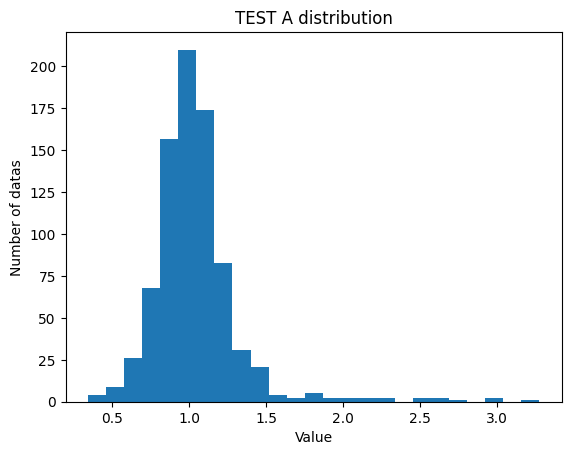

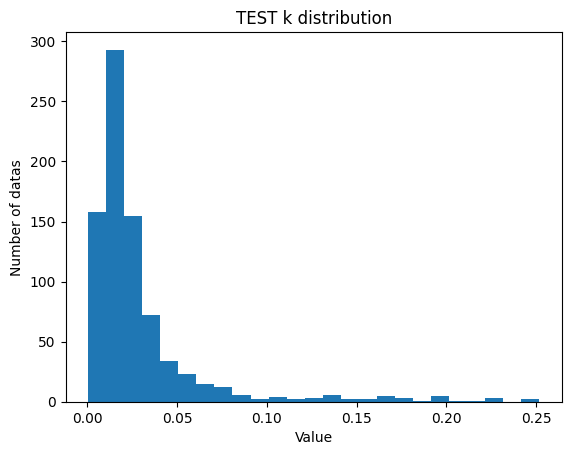

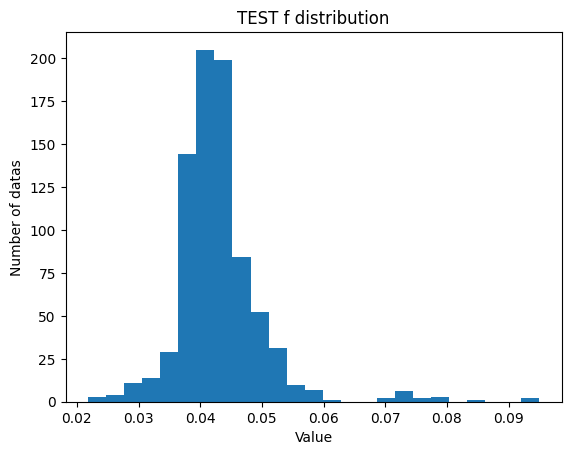

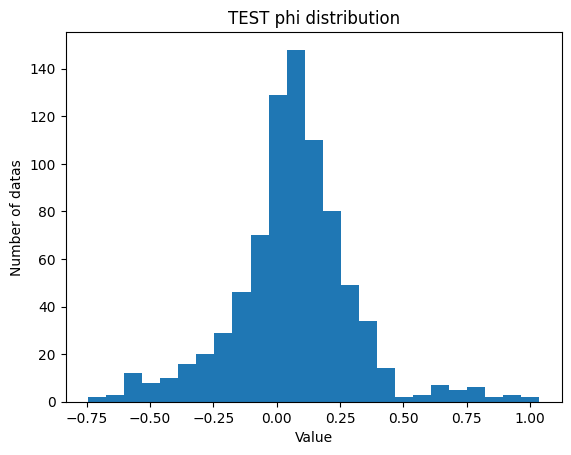

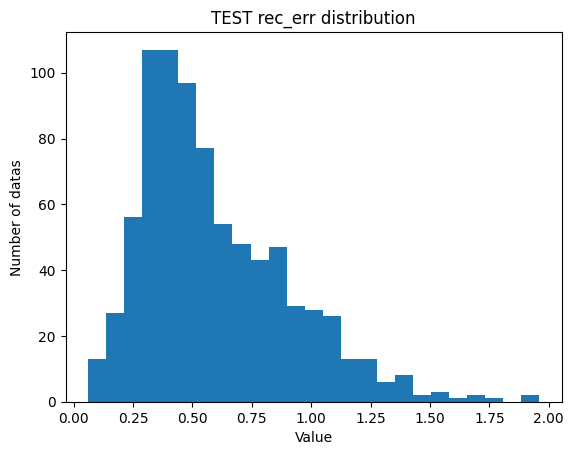

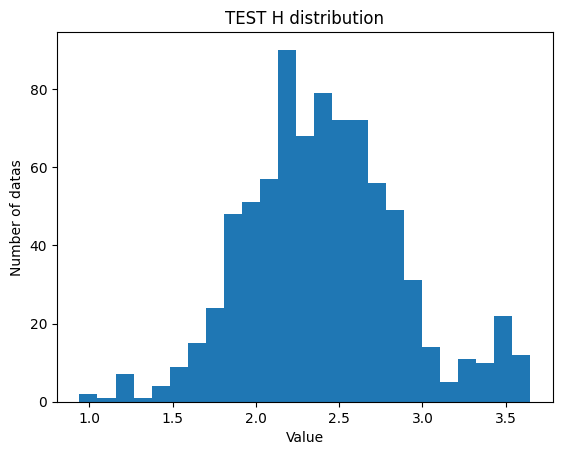

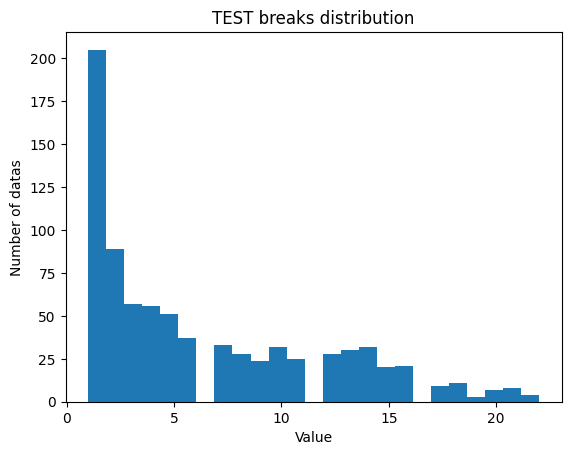

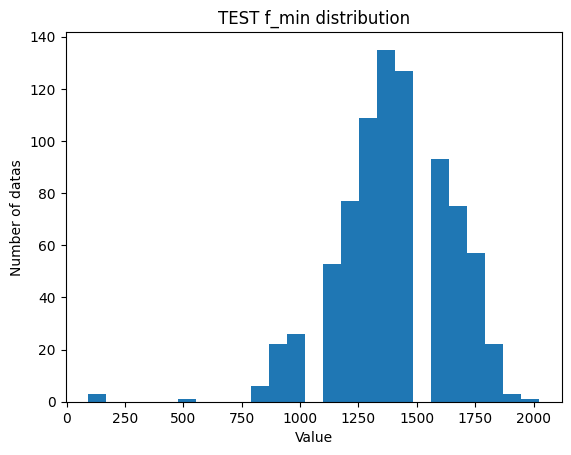

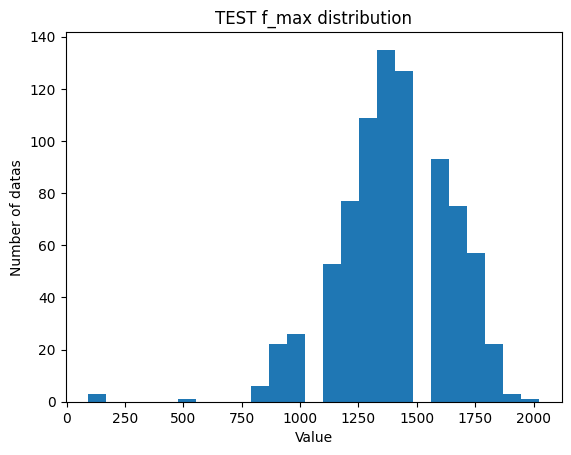

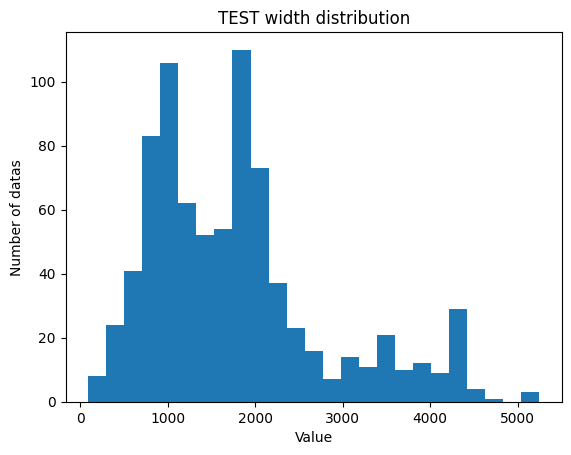

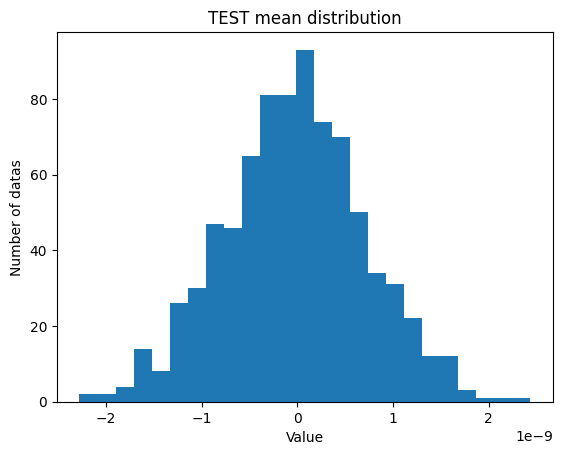

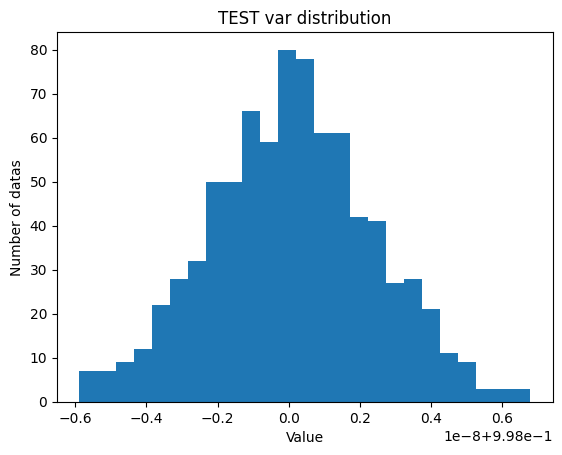

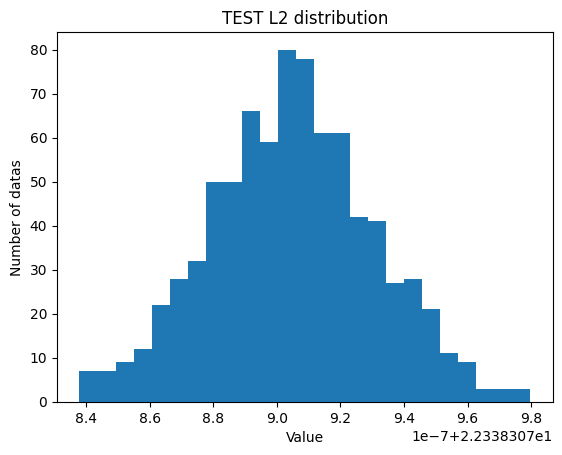

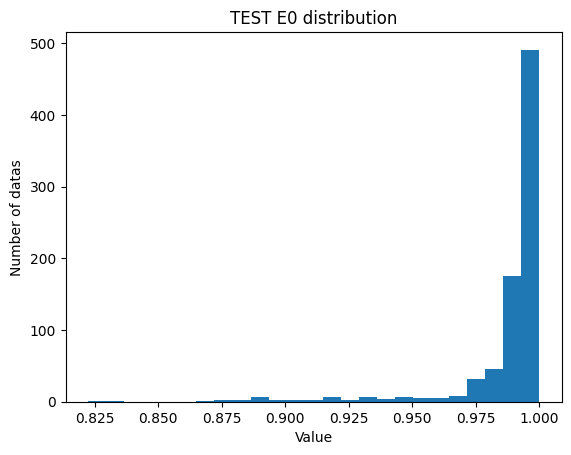

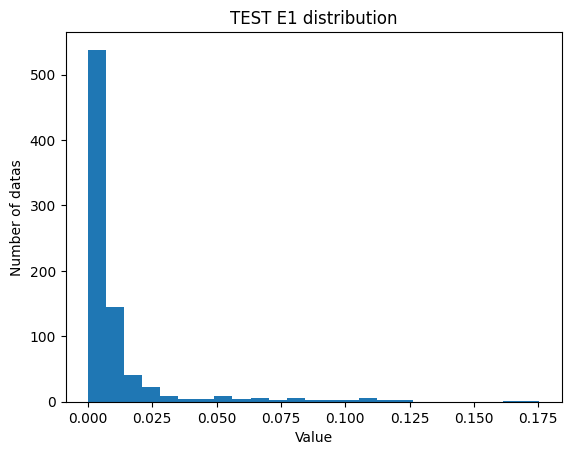

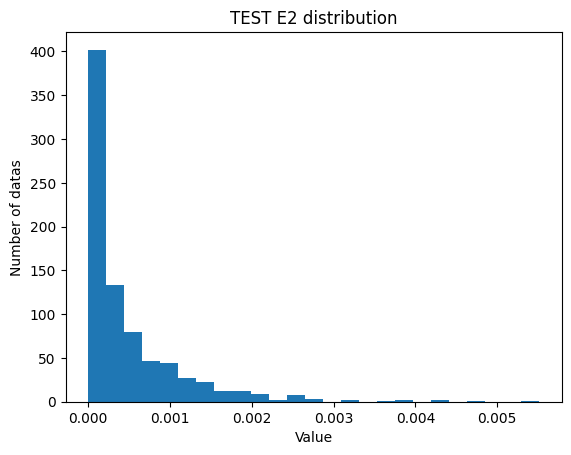

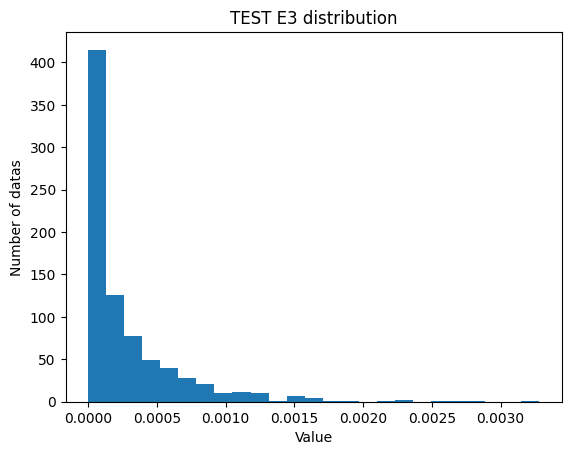

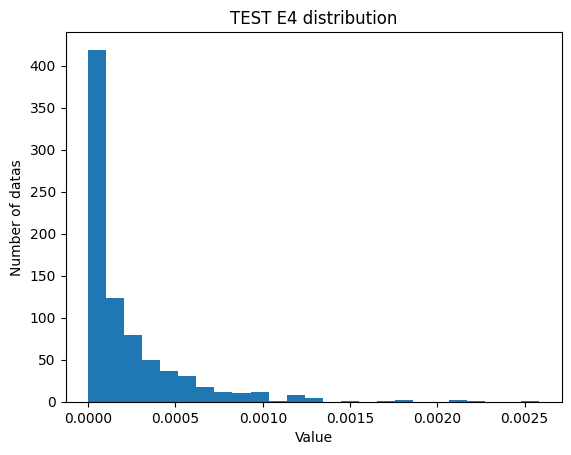

In [37]:
for feature_index, feature_name in enumerate(test_database.feature_names):
    plt.clf()
    plt.hist(test_database.X[feature_index,:], bins = 25)
    plt.title(f'TEST {feature_name} distribution')
    plt.xlabel('Value')
    plt.ylabel('Number of datas')
    plt.show()

All features with non pertinent distribution are removed

In [38]:
selected_features_names = ['k', 'rec_err','width', 'H', 'breaks']


## 12. PCA analysis

## 12.1. Features selection

In [39]:
train_features_contributions, train_data_projections, train_principal_component_variance_contribution = train_database.PCA(selected_features_names)
test_features_contributions, test_data_projections, test_principal_component_variance_contribution = test_database.PCA(selected_features_names)


(5, 3636)
(5, 810)


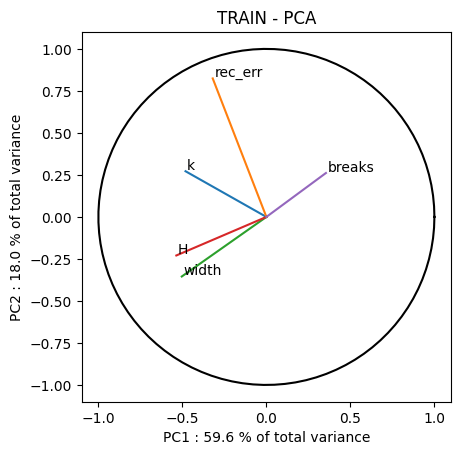

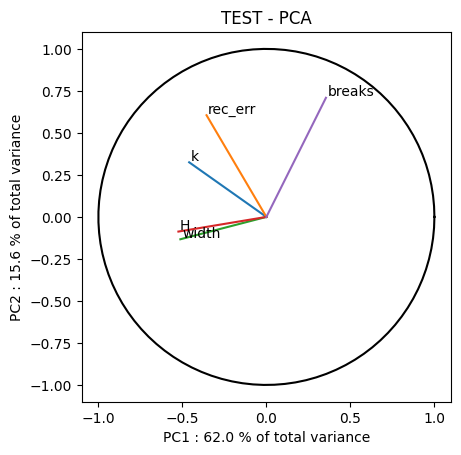

In [40]:
plot_PCA_circle(train_features_contributions, selected_features_names, train_data_projections, train_principal_component_variance_contribution, database_name = 'TRAIN')
plot_PCA_circle(test_features_contributions, selected_features_names, test_data_projections, test_principal_component_variance_contribution, database_name = 'TEST')

Breaks does not seem to be coherent between the train and test set so we choose to remove it.

In [41]:
selected_features_names = ['k', 'rec_err','width', 'H']


In [42]:
train_features_contributions, train_data_projections, train_principal_component_variance_contribution = train_database.PCA(selected_features_names)
test_features_contributions, test_data_projections, test_principal_component_variance_contribution = test_database.PCA(selected_features_names)

(4, 3636)
(4, 810)


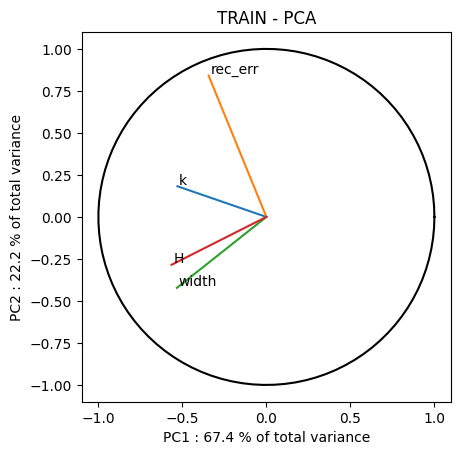

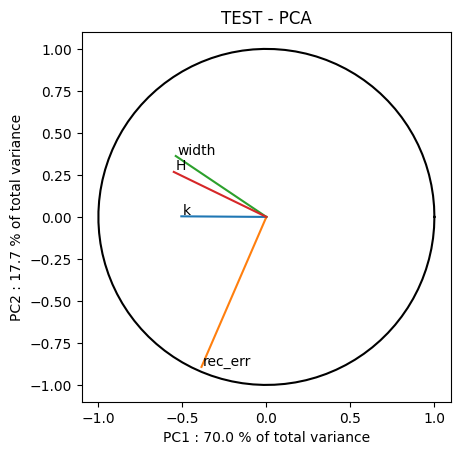

In [43]:
plot_PCA_circle(train_features_contributions, selected_features_names, train_data_projections, train_principal_component_variance_contribution, database_name = 'TRAIN')
plot_PCA_circle(test_features_contributions, selected_features_names, test_data_projections, test_principal_component_variance_contribution, database_name = 'TEST')

rec_err does not seem to be coherent between the train and test set so we choose to remove it.

In [44]:
features_names = ['k', 'H', 'width']


In [45]:
train_features_contributions, train_data_projections, train_principal_component_variance_contribution = train_database.PCA(features_names)
test_features_contributions, test_data_projections, test_principal_component_variance_contribution = test_database.PCA(features_names)

(3, 3636)
(3, 810)


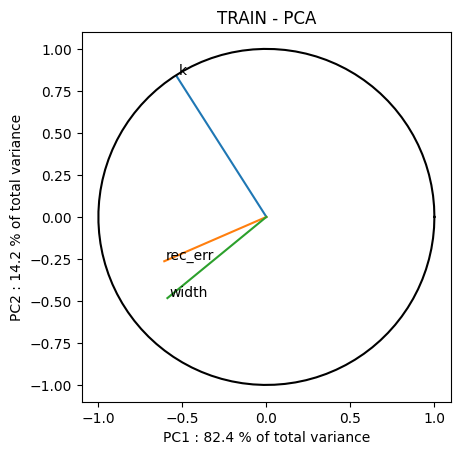

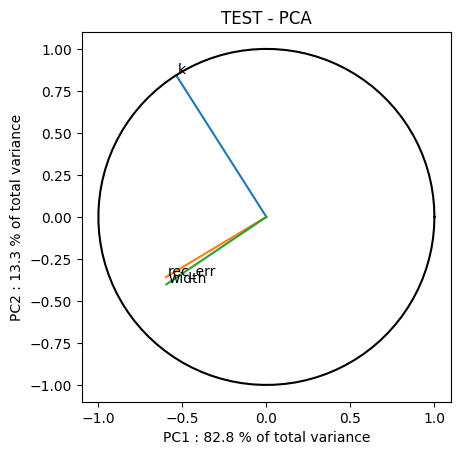

In [46]:
plot_PCA_circle(train_features_contributions, selected_features_names, train_data_projections, train_principal_component_variance_contribution, database_name = 'TRAIN')
plot_PCA_circle(test_features_contributions, selected_features_names, test_data_projections, test_principal_component_variance_contribution, database_name = 'TEST')

The train and test plots seem coherent.

## 12.2. Visualisation in the selected feature space

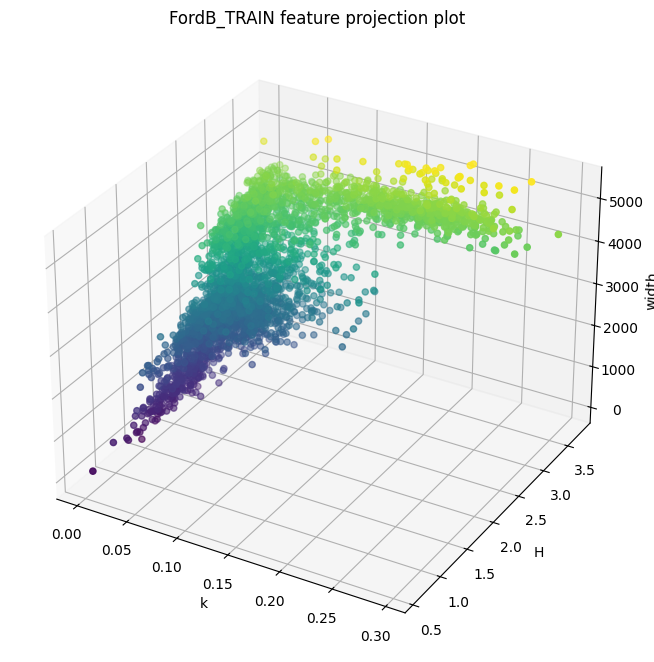

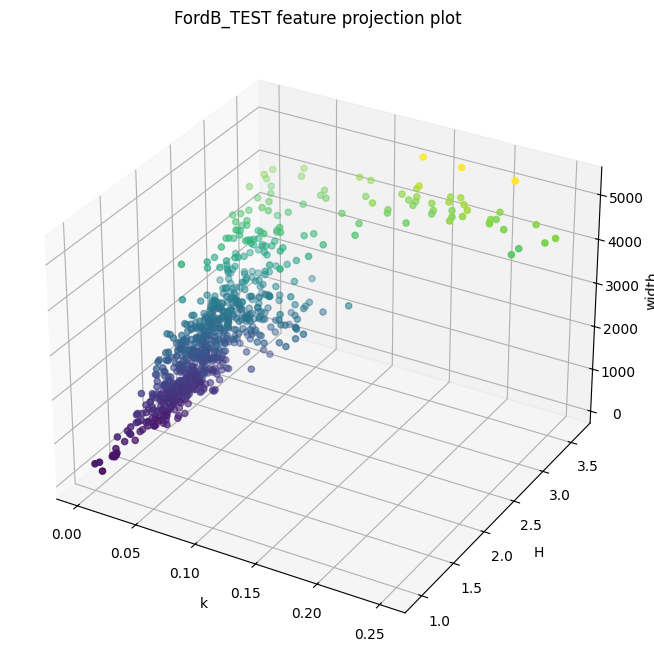

In [47]:
plot_database_in_3_features_space(features_names, train_database, clustering = '')
plot_database_in_3_features_space(features_names, test_database, clustering = '')

#

# 13. Clustering

## 13.1. Clustering computation on the previously selected features

In [48]:
train_database.k_mean_clustering(features_names)
test_database.k_mean_clustering(features_names)

## 13.2. Clustering visualisation

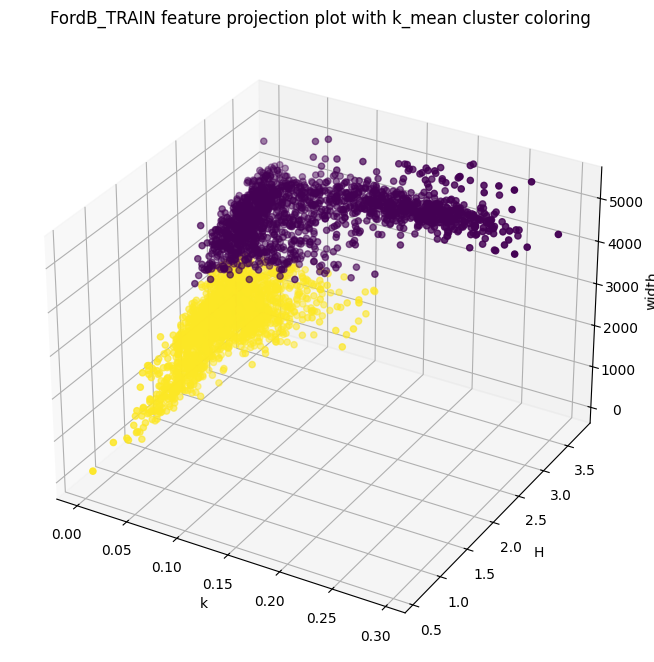

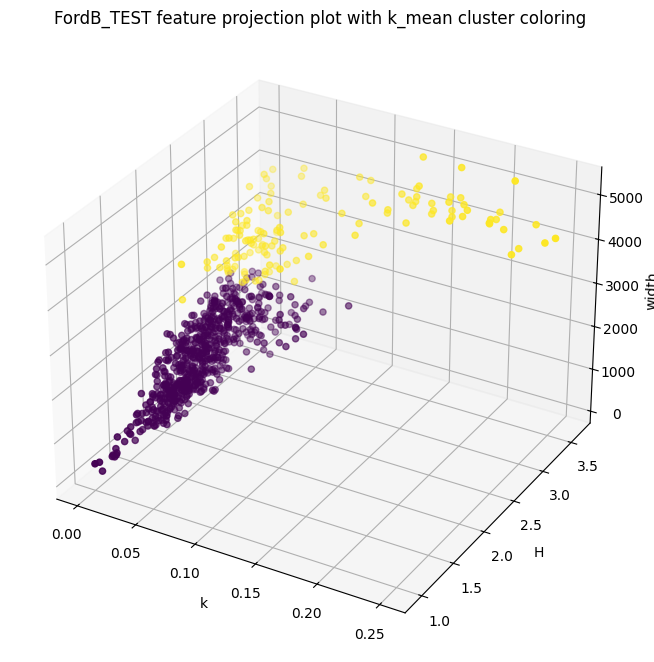

In [49]:
plot_database_in_3_features_space(features_names, train_database, clustering = 'k_mean')
plot_database_in_3_features_space(features_names, test_database, clustering = 'k_mean')

## 13.3. Principal Component-space clustering plot

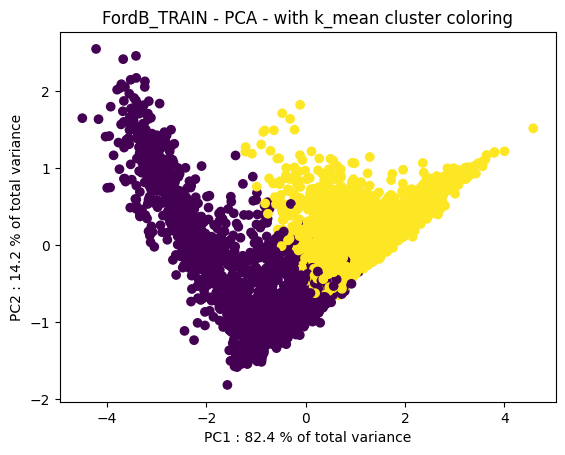

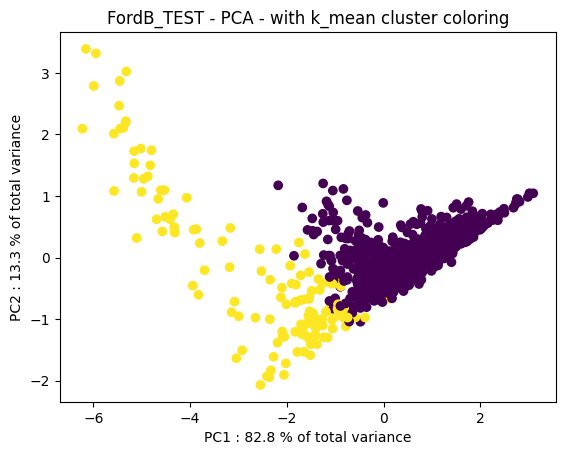

In [50]:
plot_PCA(train_database, train_features_contributions, features_names, train_data_projections, train_principal_component_variance_contribution, database_name = 'TRAIN', clustering = 'k_mean', plot_pca_circle = False)
plot_PCA(test_database, test_features_contributions, features_names, test_data_projections, test_principal_component_variance_contribution, database_name = 'TEST', clustering = 'k_mean', plot_pca_circle = False)


# 14. Saving the feature matrix reduced to the 3 selected features

In [52]:
train_final_feature_matrix = get_reduced_feature_matrix(train_database, features_names)
test_final_feature_matrix = get_reduced_feature_matrix(test_database, features_names)

np.savez("train_final_feature_matrix.npz", tableau=train_final_feature_matrix)
np.savez("test_final_feature_matrix.npz", tableau=test_final_feature_matrix)
